# Exploratory Data Analysis

- Structure & Basic Info
- Summary Statistics
- Vizualizing Distributions
- Exploring Relationships
- Spotting Issues

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('/Users/kolesnikevgenia/Documents/Python_Projects/Job_Skills/Raw_Data/df_Final.csv')

### Structure & Basic Info

In [3]:
df.shape


(22003, 21)

In [4]:
df.dtypes

job_title_short           object
job_title                 object
job_location              object
job_via                   object
job_schedule_type         object
job_work_from_home          bool
search_location           object
job_posted_date           object
job_no_degree_mention       bool
job_health_insurance        bool
job_country               object
salary_rate               object
company_name              object
job_skills                object
job_type_skills           object
salary_year_avg_eur      float64
salary_month_avg_eur     float64
country                   object
is_eu                       bool
ISO                       object
region_group              object
dtype: object

In [5]:
df.isna().sum()

job_title_short              0
job_title                    0
job_location               280
job_via                      0
job_schedule_type           16
job_work_from_home           0
search_location              0
job_posted_date              0
job_no_degree_mention        0
job_health_insurance         0
job_country                  0
salary_rate                  0
company_name                 0
job_skills                1833
job_type_skills           1833
salary_year_avg_eur          0
salary_month_avg_eur         0
country                  20349
is_eu                        0
ISO                      20349
region_group                 0
dtype: int64

### Summary Statistics

In [6]:
#Numeric column
df['salary_month_avg_eur'].describe().round(0).astype(int)

count    22003
mean      8945
std       3505
min       1088
25%       6530
50%       8344
75%      10884
max      69656
Name: salary_month_avg_eur, dtype: int64

In [7]:
#Categorical counts
df['job_title_short'].value_counts().head(10)

job_title_short
Data Scientist               5922
Data Analyst                 5451
Data Engineer                4500
Senior Data Scientist        1690
Senior Data Engineer         1591
Senior Data Analyst          1131
Business Analyst              610
Machine Learning Engineer     576
Software Engineer             467
Cloud Engineer                 65
Name: count, dtype: int64

In [8]:
df['job_country'].value_counts().head(10)

job_country
United States     15766
Sudan              1623
India               582
Canada              463
United Kingdom      287
Germany             257
France              237
Poland              200
Spain               144
Portugal            131
Name: count, dtype: int64

In [9]:
#Median salary by country
df.groupby('job_country')['salary_month_avg_eur'].median().sort_values(ascending=False).round(0).astype(int).head(10)

job_country
Belarus                     29023
Russia                      21768
Bahamas                     15100
Dominican Republic          11428
Northern Mariana Islands    11282
Tunisia                     10702
Côte d'Ivoire               10702
Chile                       10594
Namibia                      9940
Sudan                        9396
Name: salary_month_avg_eur, dtype: int64

In [10]:
#Exploring median salaries by country
df = df.dropna(subset=['salary_month_avg_eur'])

country_salary_stats = (
    df.groupby('job_country')
    .agg(job_count=('salary_month_avg_eur', 'count'),
         avg_salary=('salary_month_avg_eur', 'mean'))
         .sort_values(by='avg_salary', ascending=False)
         ).round(0).astype(int)

country_salary_stats.head(10)

,job_count,avg_salary
job_country,,
Belarus,1,29023
Russia,4,21223
Bahamas,21,14621
Dominican Republic,1,11428
Northern Mariana Islands,1,11282
Côte d'Ivoire,1,10702
Namibia,7,10220
Sudan,1623,9727
United States,15766,9152


### Visualizing Distributions

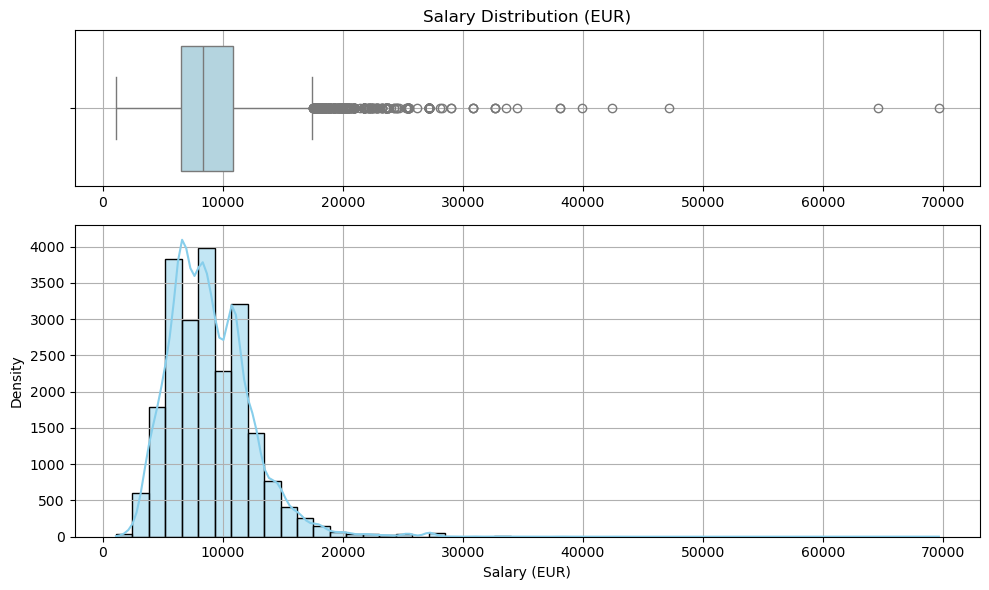

In [11]:
data = df['salary_month_avg_eur'].dropna()
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 6), gridspec_kw={'height_ratios': [1, 2]})

# --- Boxplot
sns.boxplot(x=data, ax=ax1, color='lightblue')
ax1.set_title('Salary Distribution (EUR)')
ax1.set_xlabel('')
ax1.grid(True)

# --- Histogram
sns.histplot(data, bins=50, kde=True, ax=ax2, color='skyblue', edgecolor='black')
ax2.set_xlabel('Salary (EUR)')
ax2.set_ylabel('Density')
ax2.grid(True)

plt.tight_layout()
plt.show()

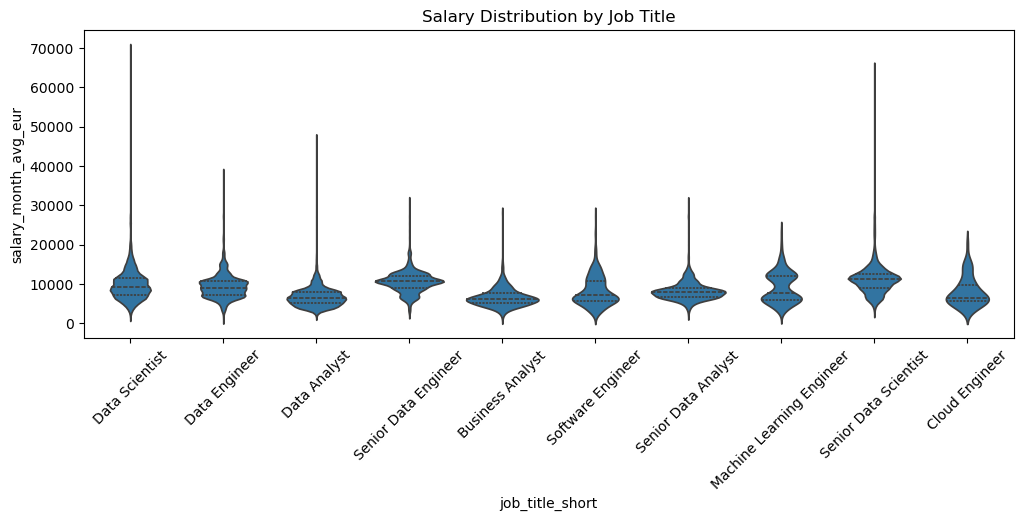

In [12]:
plt.figure(figsize=(12, 4))
sns.violinplot(data=df, x='job_title_short', y='salary_month_avg_eur', inner='quartile')
plt.xticks(rotation=45)
plt.title('Salary Distribution by Job Title')
plt.show()

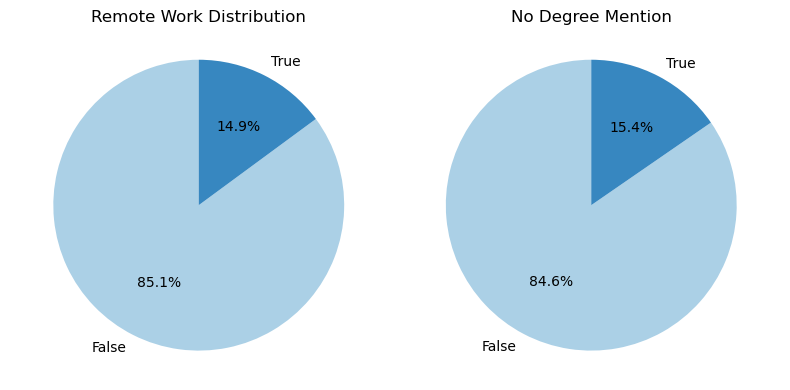

In [13]:
remote_counts = df['job_work_from_home'].value_counts()
degree_counts = df['job_no_degree_mention'].value_counts()

# Shared color palette
shared_colors = sns.color_palette("Blues", n_colors=2)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Remote Work Pie Chart
axes[0].pie(
    remote_counts,
    labels=remote_counts.index.astype(str),
    autopct='%1.1f%%',
    startangle=90,
    colors=shared_colors
)
axes[0].set_title('Remote Work Distribution')
axes[0].axis('equal')

# No Degree Mention Pie Chart
axes[1].pie(
    degree_counts,
    labels=degree_counts.index.astype(str),
    autopct='%1.1f%%',
    startangle=90,
    colors=shared_colors
)
axes[1].set_title('No Degree Mention')
axes[1].axis('equal')

# Layout
plt.tight_layout()
plt.show()

### Exploring Relationships

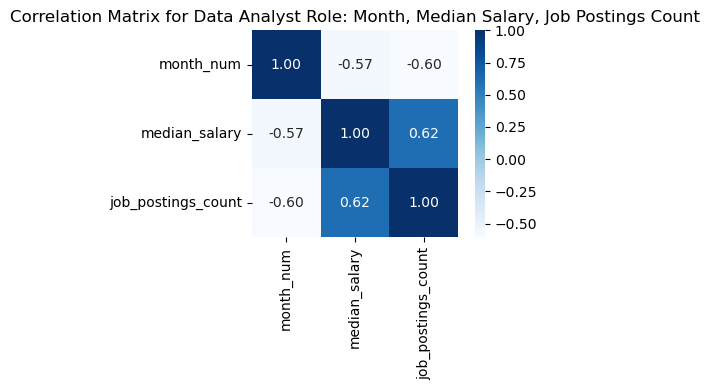

In [19]:
df_da = df[(df['job_title_short'] == 'Data Analyst')].copy()

df_da['job_posted_date'] = pd.to_datetime(df_da['job_posted_date'])
df_da['month_num'] = df_da['job_posted_date'].dt.month

# Group by month to get median salary and job count
monthly_stats = df_da.groupby('month_num').agg(
    median_salary=('salary_month_avg_eur', 'median'),
    job_postings_count=('salary_month_avg_eur', 'count')  # or 'size' if column doesn't matter
).reset_index()

# Correlation matrix
correlation_matrix = monthly_stats.corr(numeric_only=True)

plt.figure(figsize=(5, 4))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="Blues", square=True)
plt.title("Correlation Matrix for Data Analyst Role: Month, Median Salary, Job Postings Count")
plt.tight_layout()
plt.show()

Correlation between month and job postings count = −0.6

This is a strong negative correlation.
It means that the number of job postings tends to drop significantly as the year goes on. For example, there may be many postings early in the year and fewer toward the end (or vice versa depending on how month numbering is defined).
This pattern could reflect hiring cycles, budget periods, or seasonality in the job market.

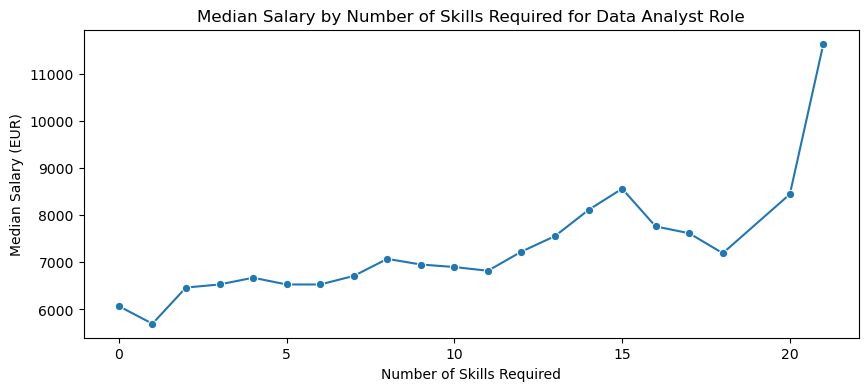

In [15]:
# Filter dataset to Data Analyst only
df_da = df[df['job_title_short'] == 'Data Analyst'].copy()

# Count skills function (comma-separated assumed)
def count_skills(skills_str):
    if pd.isna(skills_str) or skills_str.strip() == '':
        return 0
    return len([s for s in skills_str.split(',') if s.strip() != ''])

# Add skills_count column
df_da['skills_count'] = df_da['job_skills'].apply(count_skills)

# Median salary by skills count
median_salary_by_skills = df_da.groupby('skills_count')['salary_month_avg_eur'].median().reset_index()

plt.figure(figsize=(10, 4))
sns.lineplot(x='skills_count', y='salary_month_avg_eur', data=median_salary_by_skills, marker='o')
plt.title('Median Salary by Number of Skills Required for Data Analyst Role')
plt.xlabel('Number of Skills Required')
plt.ylabel('Median Salary (EUR)')
plt.show()

### Spotting Issues

In [16]:
# Check for duplicates
print(df.duplicated().sum())

1


In [17]:
df[df.duplicated(keep=False)]

,job_title_short,job_title,job_location,job_via,job_schedule_type,job_work_from_home,search_location,job_posted_date,job_no_degree_mention,job_health_insurance,...,salary_rate,company_name,job_skills,job_type_skills,salary_year_avg_eur,salary_month_avg_eur,country,is_eu,ISO,region_group
18411,Data Analyst,Data Analyst,Anywhere,via Get.It,Full-time,True,"New York, United States",2023-09-11 10:00:24,False,True,...,year,Get It Recruit - Real Estate,"['sql', 'bigquery', 'tableau', 'ssrs']","{'analyst_tools': ['tableau', 'ssrs'], 'cloud'...",78363.0,6530.25,NaN,False,NaN,US
18751,Data Analyst,Data Analyst,Anywhere,via Get.It,Full-time,True,"New York, United States",2023-09-11 10:00:24,False,True,...,year,Get It Recruit - Real Estate,"['sql', 'bigquery', 'tableau', 'ssrs']","{'analyst_tools': ['tableau', 'ssrs'], 'cloud'...",78363.0,6530.25,NaN,False,NaN,US
